In this notebook I'm trying to recover time_id order based on denormalized prices using minimum tick size idea from [The Leak](https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/256725) discussion, and after use this information to improve model performance.

**Update:**

As the discussion was deleted, I will briefly explain the idea here, though whole credit for finding it belongs to @nquay3. Actually it is quite simple and is based on 2 facts:
1. Stock prices are changing not by arbitrarty real value but by multiples of minimum possible price change called *tick size*, which is usually equals to \\$0.01, though it might be different for certain stocks and exchanges.
2. From the host [answer](https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/249752#1384739) we know that prices were normalized by dividing them by the price (WAP to be precise) at seconds_in_bucket=0 for each stock_id/time_id. So tick size will also be divided by this price.

Then if we find normalized tick size by taking minimum of all price changes for each stock_id/time_id, and assuming real tick size=\\$0.01, we can restore original price as: 

$S_0=\frac{0.01}{normalized\_tick\_size}$.

In [1]:
#!pip install yfinance

In [16]:
%%capture
import umap
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'
sns.set_theme('notebook', 'white', font_scale=1.2, palette='tab10')

In [3]:
data_dir = '/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data'
df_files = pd.DataFrame({'book_path': glob(f'{data_dir}/book_train.parquet/**/*.parquet')}) \
    .assign(stock_id=lambda x: x.book_path.str.extract("stock_id=(\d+)").astype('int')) \
    .sort_values('stock_id')
df_target_train = pd.read_csv(f'{data_dir}/train.csv')
df_volatility_train = df_target_train.groupby('time_id').target.mean()

In [4]:
def rmspe(y_true, y_pred):
    return ((((y_true - y_pred) / y_true)) ** 2).mean() ** 0.5

def plot_price(stock_id, time_id, price_name, kind, ax):
    r = df_files.query(f'stock_id == {stock_id}').iloc[0]
    df = pd.read_parquet(r.book_path, columns=['time_id', 'seconds_in_bucket', price_name])
    df = df.query(f'time_id == {time_id}').drop(columns='time_id').set_index('seconds_in_bucket').reindex(np.arange(600), method='ffill')
    min_diff = np.nanmin(abs(df[price_name].diff().where(lambda x: x > 0)))
    if kind == 'price_norm':
        df[price_name].plot.line(legend=False, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} normalized')
    elif kind == 'price_change':
        df = df[price_name].diff().reset_index()
        df.plot.bar(x='seconds_in_bucket', y=price_name, color=np.where(df[price_name] > 0, 'g', 'r'), legend=False, edgecolor='none', width=1, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} change')
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(min_diff))
    elif kind == 'ticks_change':
        df = df[price_name].diff().div(min_diff).reset_index()
        df.plot.bar(x='seconds_in_bucket', y=price_name, color=np.where(df[price_name] > 0, 'g', 'r'), legend=False, edgecolor='none', width=1, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} change (ticks)')
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    elif kind == 'price_original':
        df[price_name] = 0.01 / min_diff * df[price_name]
        df[price_name].plot.line(legend=False, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} original')

    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30))
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    ax.set_xlim(0, 600)
    
def plot_emb(emb, color, name, kind='volatility', fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    if kind == 'volatility':
        norm = mpl.colors.LogNorm()
        ticks = mpl.ticker.LogLocator(2)
        formatter = mpl.ticker.ScalarFormatter()
    elif kind == 'date':
        norm = None
        ticks = None
        formatter = mpl.dates.AutoDateFormatter(mpl.dates.MonthLocator())
    plot = ax.scatter(emb[:, 0], emb[:, 1], s=3, c=color, edgecolors='none', cmap='jet', norm=norm);
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)    
    cb = fig.colorbar(plot, label=kind, format=formatter,
                      ticks=ticks, cax=cax)
    cb.ax.minorticks_off()
    ax.set_title(f'{name}')

To better understand the idea let's plot some charts for selected stock_id/time_id:
1. First chart is normalized to 1 price as it is in training dataset
2. Second chart - is normalized price changes `price.diff()`. You can clearly see that they are all integer multiples of some real value.
3. Third chart is just the same as second, but divided by min price change `price.diff() / min(price.diff())`, thus we get price changes in ticks. Here you can see it even better that price changes by integer number of ticks.
4. Tha last chart is reconstructed price `price * 0.01 / min(price.diff())`

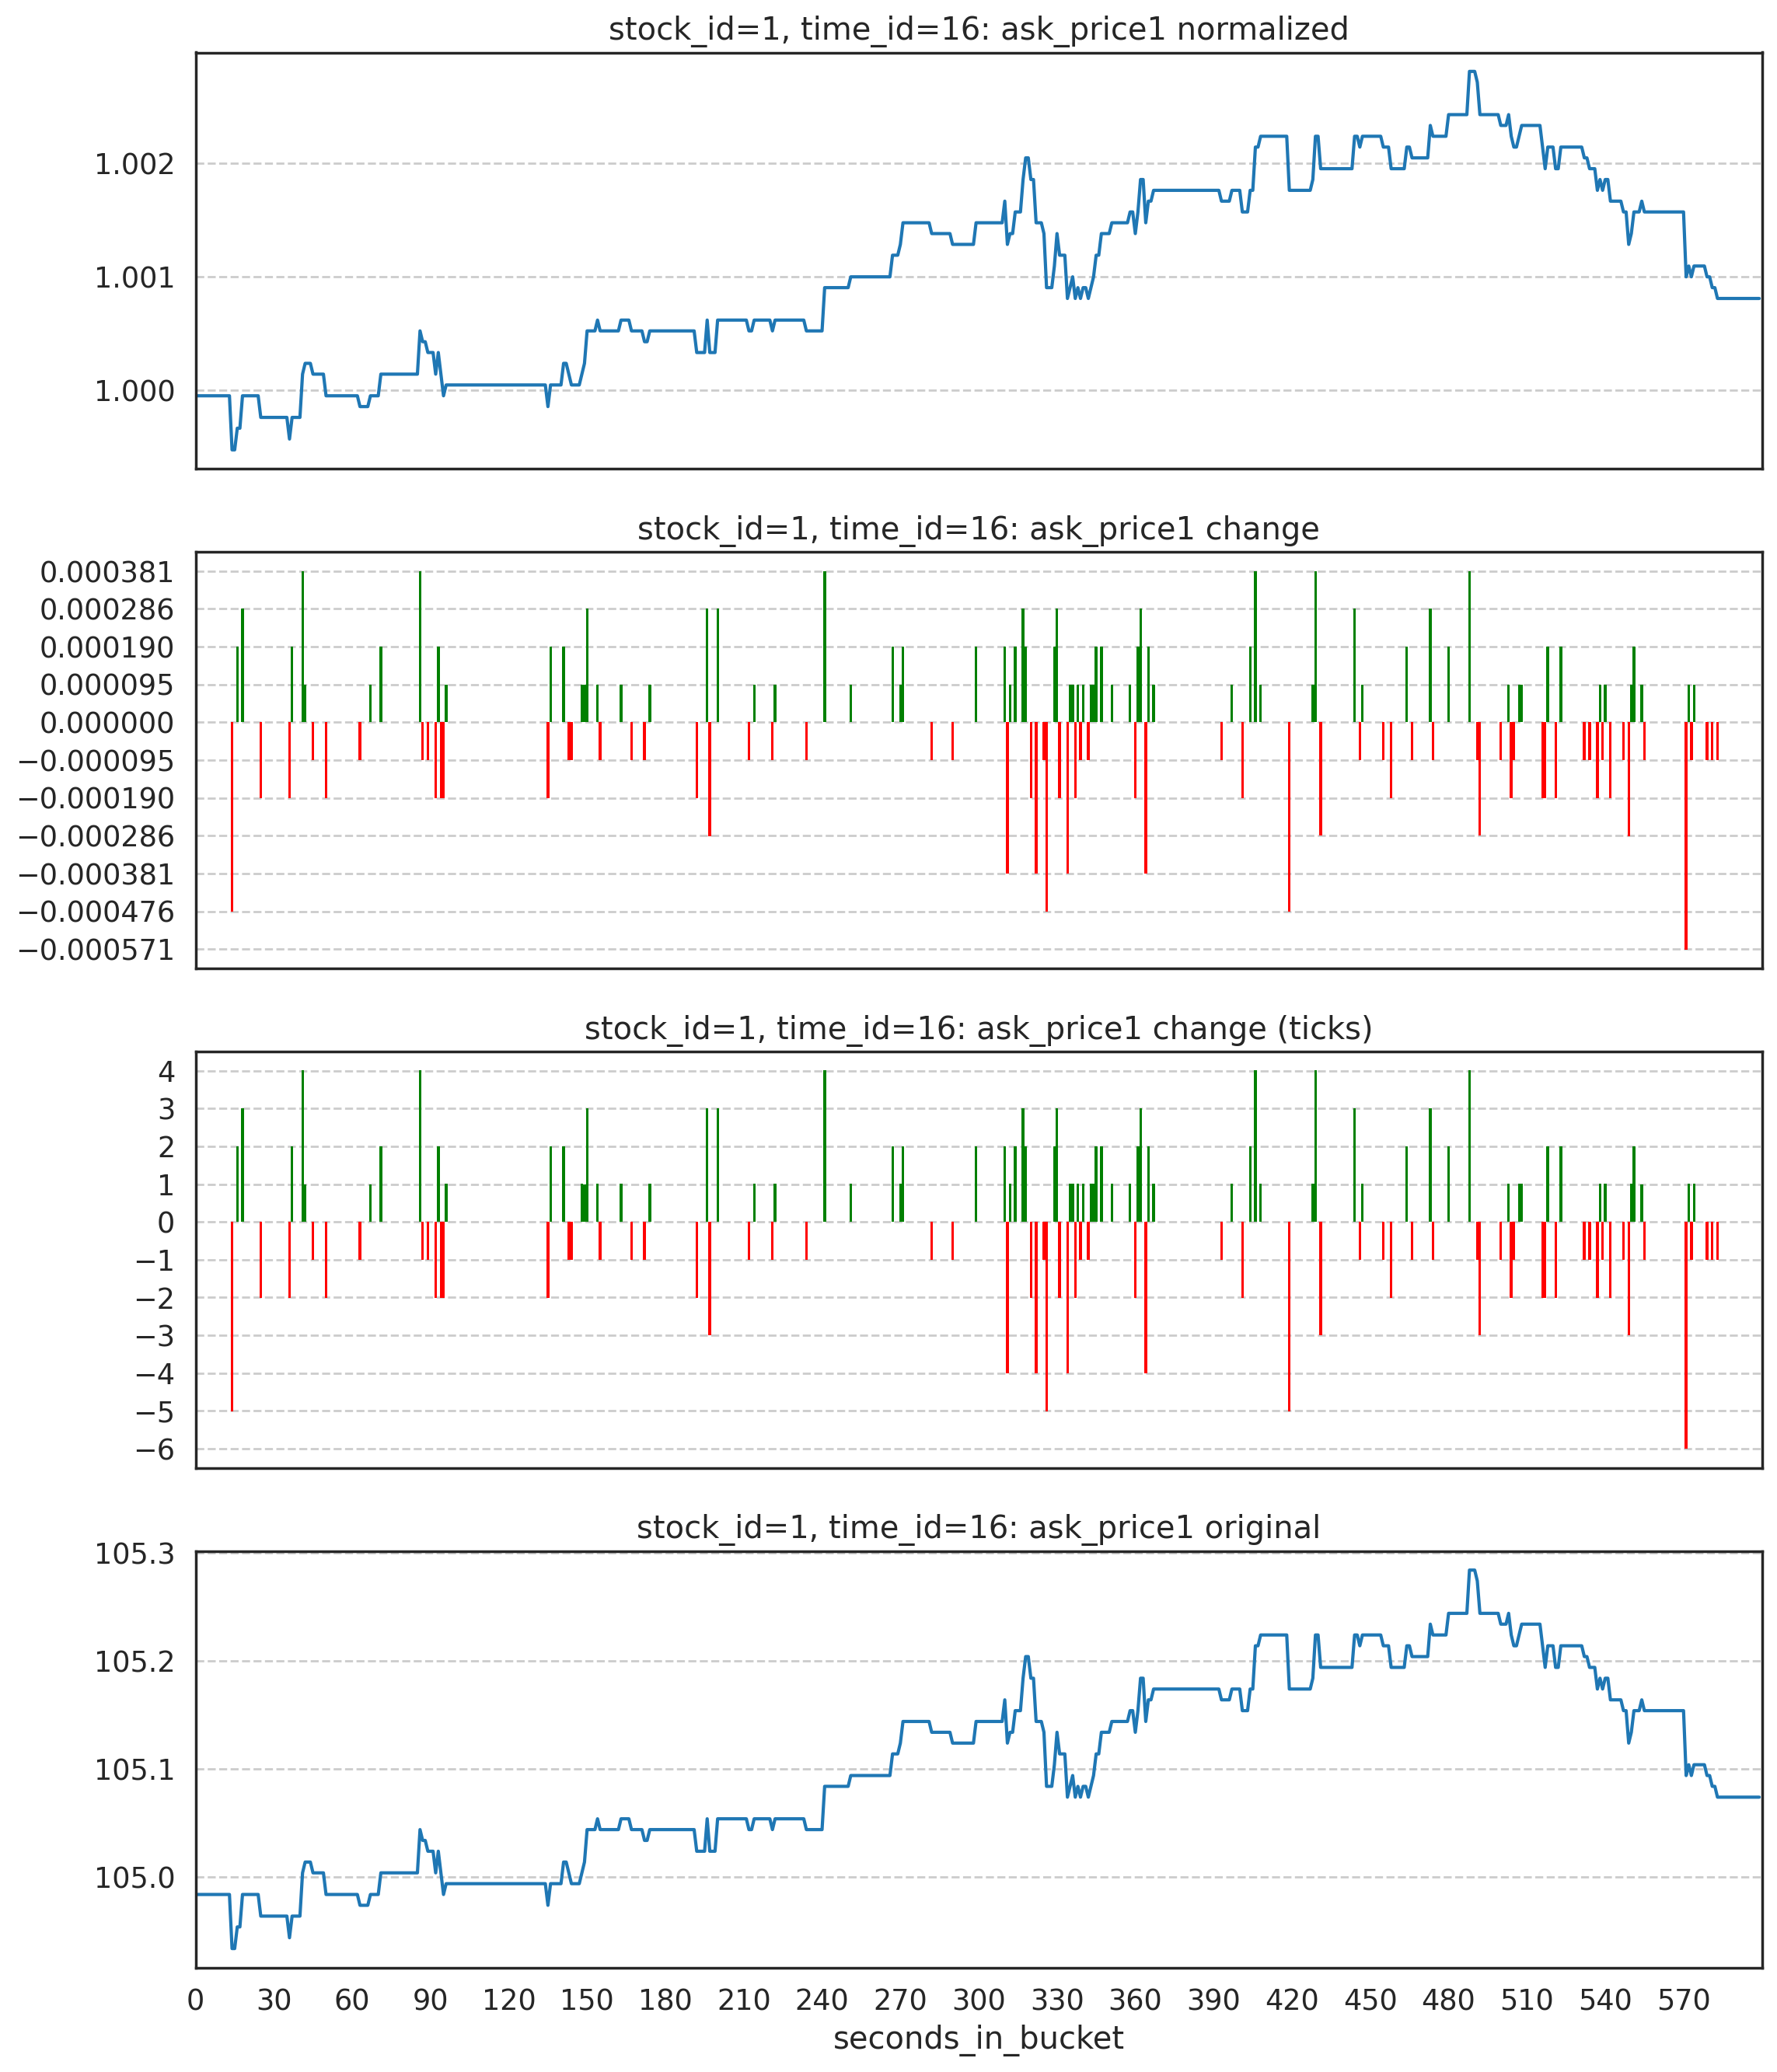

In [5]:
f, ax = plt.subplots(4, 1, sharex=True, figsize=(13, 16))        
plot_price(1, 16, 'ask_price1', 'price_norm', ax[0])
plot_price(1, 16, 'ask_price1', 'price_change', ax[1])
plot_price(1, 16, 'ask_price1', 'ticks_change', ax[2])
plot_price(1, 16, 'ask_price1', 'price_original', ax[3])

Now let's recover original prices for each stock_id/time_id and explore them.

In [6]:
def calc_price(df):
    diff = abs(df.diff())
    min_diff = np.nanmin(diff.where(lambda x: x > 0))
    n_ticks = (diff / min_diff).round()
    return 0.01 / np.nanmean(diff / n_ticks)

def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.groupby('time_id').apply(calc_price).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df

In [7]:
df_prices_denorm = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))

/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_61166/54321953.py:3: RuntimeWarning: All-NaN axis encountered
/tmp/ipykernel_61166/54321953

Here are recovered prices:

In [8]:
df_prices_denorm = df_prices_denorm.pivot(index='time_id',columns='stock_id', values='price')
df_prices_denorm

stock_id         0           1           2           3           4    \
time_id                                                                
5         193.382499  152.416327  123.461428  226.012232  619.198910   
11        199.230489  149.512019  128.641219  249.893186  614.775587   
16        208.900108  104.885672  118.687626  164.755260  534.006468   
31        216.138269  137.831207  138.326846  235.951400  657.637025   
62        214.516335  140.650237  137.213402  238.242521  639.647230   
...              ...         ...         ...         ...         ...   
32751     192.207769  148.865368  132.110590  243.722214  652.082489   
32753     199.748994  143.562752  128.829956  245.019729  616.837441   
32758     198.471328  111.979022  142.683929  216.825656  591.479678   
32763     208.002502   81.295087  116.000506  107.229172  516.903933   
32767     208.721071  101.052147  128.278257  199.130195  564.778295   

stock_id         5           6           7           8           9    ...  \
time_id                                                               ...   
5         738.256609  370.275801  245.870983  283.881404  238.394801  ...   
11        769.481159  411.690103  256.711224  278.116800  244.391095  ...   
16        584.016561  236.595134  208.127709  123.656642  177.405905  ...   
31        804.561657  358.949356  260.607163  194.206656  232.626591  ...   
62        765.430361  403.068356  250.621870  187.756607  243.460002  ...   
...              ...         ...         ...         ...         ...  ...   
32751     745.338533  389.702447  252.020435  252.114143  230.046724  ...   
32753     755.527664  389.036260  249.891005  258.463170  241.465759  ...   
32758     729.433334  509.977233  234.174952  132.590478  206.086532  ...   
32763     502.602869  143.001750  182.616348   94.160764  162.246740  ...   
32767     683.743827  254.351346  245.839823  116.209637  185.205086  ...   

stock_id        115         116         118        119         120  \
time_id                                                              
5         88.143530  246.326035  210.790493  66.225351   96.217049   
11        90.285607  275.920002  213.987639  63.064600  101.239489   
16        70.035150  189.724268  281.007926  53.520546   74.554427   
31        90.688217  256.869865  235.129520  61.245171   90.928457   
62        89.140911  248.061738  231.193774  59.542960   87.940275   
...             ...         ...         ...        ...         ...   
32751     88.523948  269.021445  241.987520  60.049757   93.429990   
32753     91.186063  269.457870  212.935865  62.066114   92.794336   
32758     80.310357  225.500215  211.873457  43.955594   80.582209   
32763     59.235750  151.293921  263.571506  44.825190   66.755134   
32767     76.478989  196.456837  280.672331  51.486737   81.482505   

stock_id         122         123        124        125         126  
time_id                                                             
5         142.352639  108.310134  84.344766  53.375172  310.446018  
11        136.924692  105.482065  91.095218  55.886795  300.948142  
16         93.370637   77.421019  55.054433  53.084003  194.495613  
31        134.847296  103.739264  92.465027  58.124482  259.149062  
62        125.482870  103.529649  96.060419  57.373160  259.214214  
...              ...         ...        ...        ...         ...  
32751     135.630818  103.531318  94.184826  56.814400  306.255498  
32753     136.533152  104.054983  87.874304  55.995629  290.136260  
32758     111.225451   89.826475  81.064096  56.597615  202.570521  
32763      77.321223   71.994967  52.124935  50.174789  151.879455  
32767     105.091738   75.074348  68.755608  55.856964  194.435959  

[3830 rows x 112 columns]

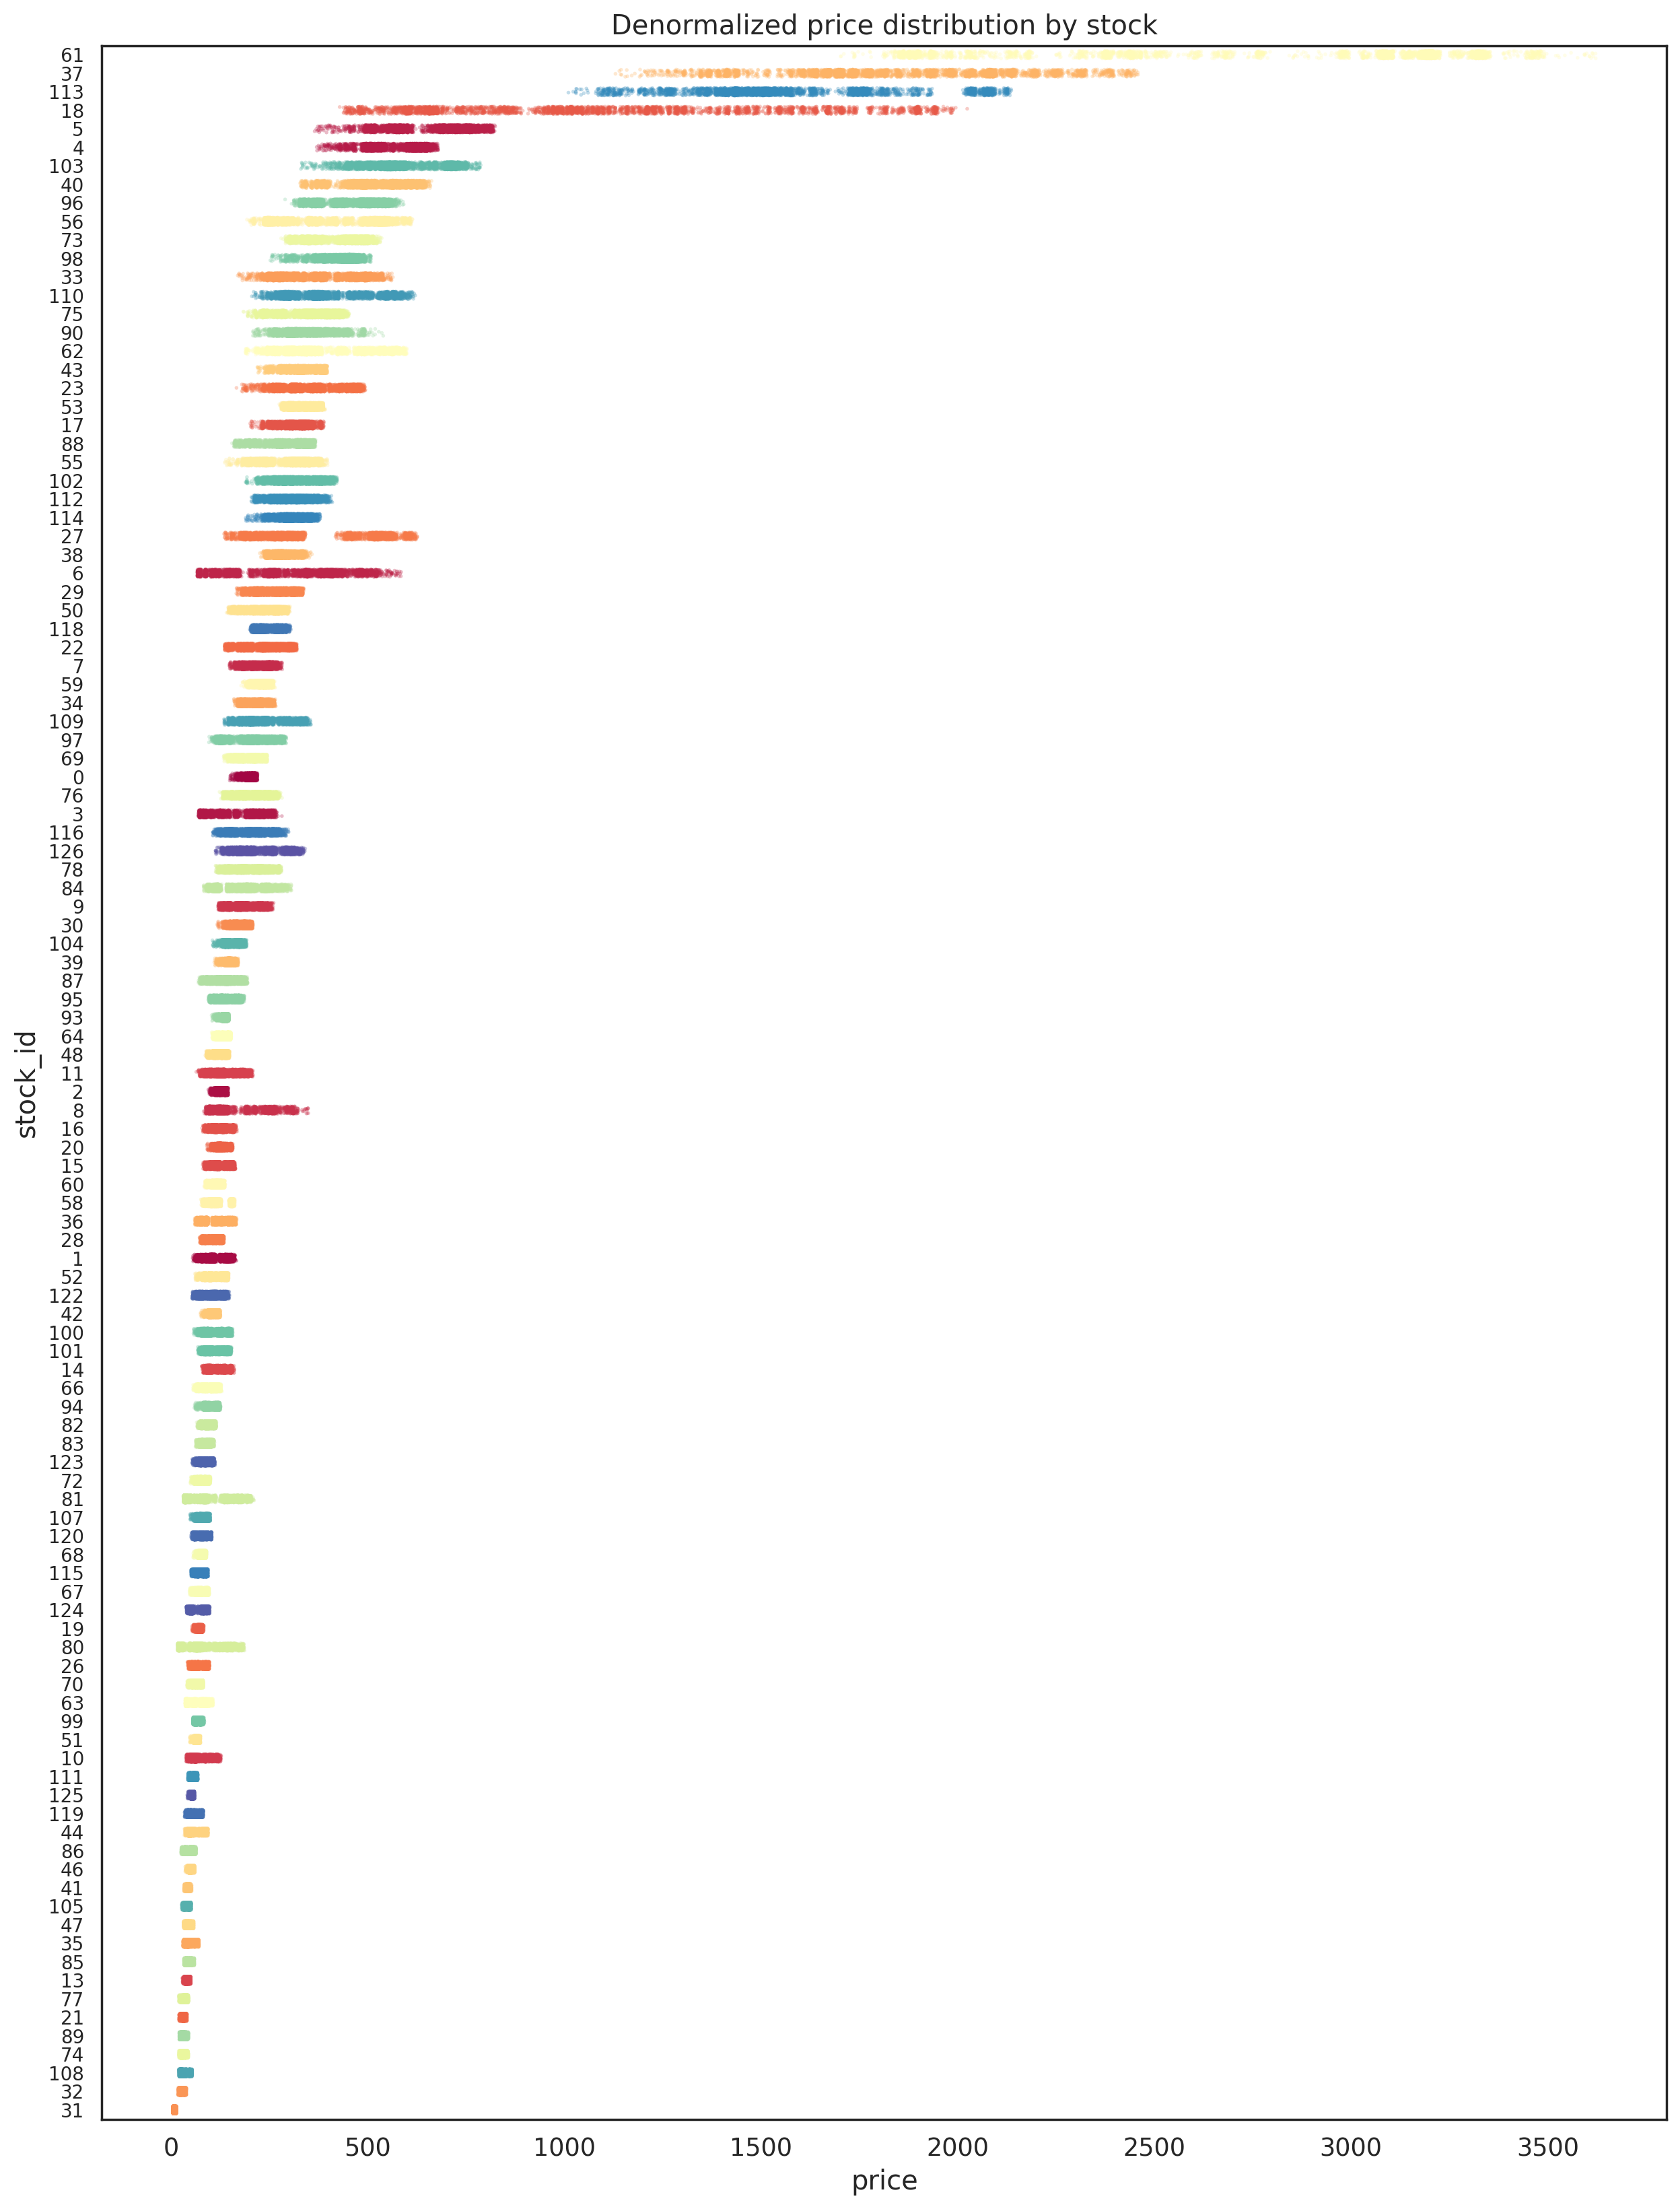

In [9]:
plt.figure(figsize=(15, 20))
ax = sns.stripplot(data=df_prices_denorm, orient='h', alpha=0.3, s=2, jitter=0.2,
                   order=df_prices_denorm.median().sort_values().index[::-1].tolist(), 
                   palette='Spectral')
ax.tick_params(axis='y', which='major', labelsize=10)
plt.xlabel('price')
plt.title('Denormalized price distribution by stock');

*Note: this idea is based on assumption that tick size is constant for all time_id/stock_id and is equal to \\$0.01, otherwise the resulting prices might be different.*

Let's also download some real stock prices for comparison from approximately the same period as training data

In [21]:
SP100_tickers = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')[2].Symbol
df_prices_real = yf.download(SP100_tickers.to_list(), start='2020-01-01', end='2021-06-01', interval='1h')
#df_prices_real = pd.read_hdf('/kaggle/input/orvp-dataset/prices_real.hdf', key='prices')

[*********************100%%**********************]  101 of 101 completed

101 Failed downloads:
['GILD', 'UNP', 'PFE', 'BAC', 'KHC', 'WFC', 'BKNG', 'VZ', 'TMUS', 'GS', 'JPM', 'MRK', 'F', 'DHR', 'NEE', 'CVX', 'DE', 'TGT', 'LLY', 'LMT', 'CMCSA', 'AIG', 'DUK', 'SPG', 'BA', 'V', 'GE', 'COP', 'MA', 'C', 'GOOG', 'EMR', 'PYPL', 'HON', 'GOOGL', 'CSCO', 'MMM', 'UPS', 'DIS', 'UNH', 'PG', 'COF', 'LIN', 'NKE', 'COST', 'HD', 'ABBV', 'MDT', 'AMT', 'ADBE', 'CAT', 'XOM', 'IBM', 'WMT', 'PM', 'CVS', 'CRM', 'AXP', 'MO', 'JNJ', 'LOW', 'NFLX', 'TMO', 'ABT', 'GD', 'DOW', 'QCOM', 'AMZN', 'SBUX', 'ORCL', 'EXC', 'META', 'AMD', 'NVDA', 'MDLZ', 'TSLA', 'RTX', 'AVGO', 'ACN', 'BK', 'INTC', 'BMY', 'MET', 'GM', 'MCD', 'SO', 'AAPL', 'CHTR', 'MS', 'BLK', 'KO', 'CL', 'PEP', 'MSFT', 'SCHW', 'FDX', 'AMGN', 'TXN', 'USB']: Exception('%ticker%: 1h data not available for startTime=1577854800 and endTime=1622520000. The requested range must be within the last 730 days.')
['T']: Exception('%ticker%: 1h data not available for s

Calculating real prices volatility from OLHC data using GARMAN-KLASS estimator (thanks @lucasmorin)

In [19]:
df_volatility_real = 1 / 2 * np.log(df_prices_real.High / df_prices_real.Low) ** 2 - \
    (2 * np.log(2) - 1) * np.log(df_prices_real.Close / df_prices_real.Open) ** 2
df_volatility_real = df_volatility_real.mean(axis=1)

df_prices_real = df_prices_real.Open.fillna(df_prices_real.Open.mean()).dropna(axis=1).sample(frac=1)
df_volatility_real = df_volatility_real.loc[df_prices_real.index]
df_prices_real

Empty DataFrame
Columns: [AAPL, ABBV, ABT, ACN, ADBE, AIG, AMD, AMGN, AMT, AMZN, AVGO, AXP, BA, BAC, BK, BKNG, BLK, BMY, BRK.B, C, CAT, CHTR, CL, CMCSA, COF, COP, COST, CRM, CSCO, CVS, CVX, DE, DHR, DIS, DOW, DUK, EMR, EXC, F, FDX, GD, GE, GILD, GM, GOOG, GOOGL, GS, HD, HON, IBM, INTC, JNJ, JPM, KHC, KO, LIN, LLY, LMT, LOW, MA, MCD, MDLZ, MDT, MET, META, MMM, MO, MRK, MS, MSFT, NEE, NFLX, NKE, NVDA, ORCL, PEP, PFE, PG, PM, PYPL, QCOM, RTX, SBUX, SCHW, SO, SPG, T, TGT, TMO, TMUS, TSLA, TXN, UNH, UNP, UPS, USB, V, VZ, WFC, WMT, ...]
Index: []

[0 rows x 101 columns]

In [20]:
df_prices_denorm_scaled = df_prices_denorm.fillna(df_prices_denorm.mean())
df_prices_denorm_scaled = pd.DataFrame(minmax_scale(df_prices_denorm_scaled), index=df_prices_denorm.index)

df_prices_real_scaled = df_prices_real.fillna(df_prices_real.mean())
df_prices_real_scaled = pd.DataFrame(minmax_scale(df_prices_real_scaled), index=df_prices_real.index)

ValueError: Found array with 0 sample(s) (shape=(0, 101)) while a minimum of 1 is required.

### Can we recover time_id order from denormalized prices?

*I found this task an intersting exercise alongside with the main competition goal, I worked on it when I was stuck with other normal ideas.*

We can treat each time_id row as a point in a 112 dimensional space, where temporally close time_ids should be close in that space. Ideally, there should be a continuous 1d manifold/curve. So lets try different dimensionality reduction methods on both denormalized and real prices for comparison.

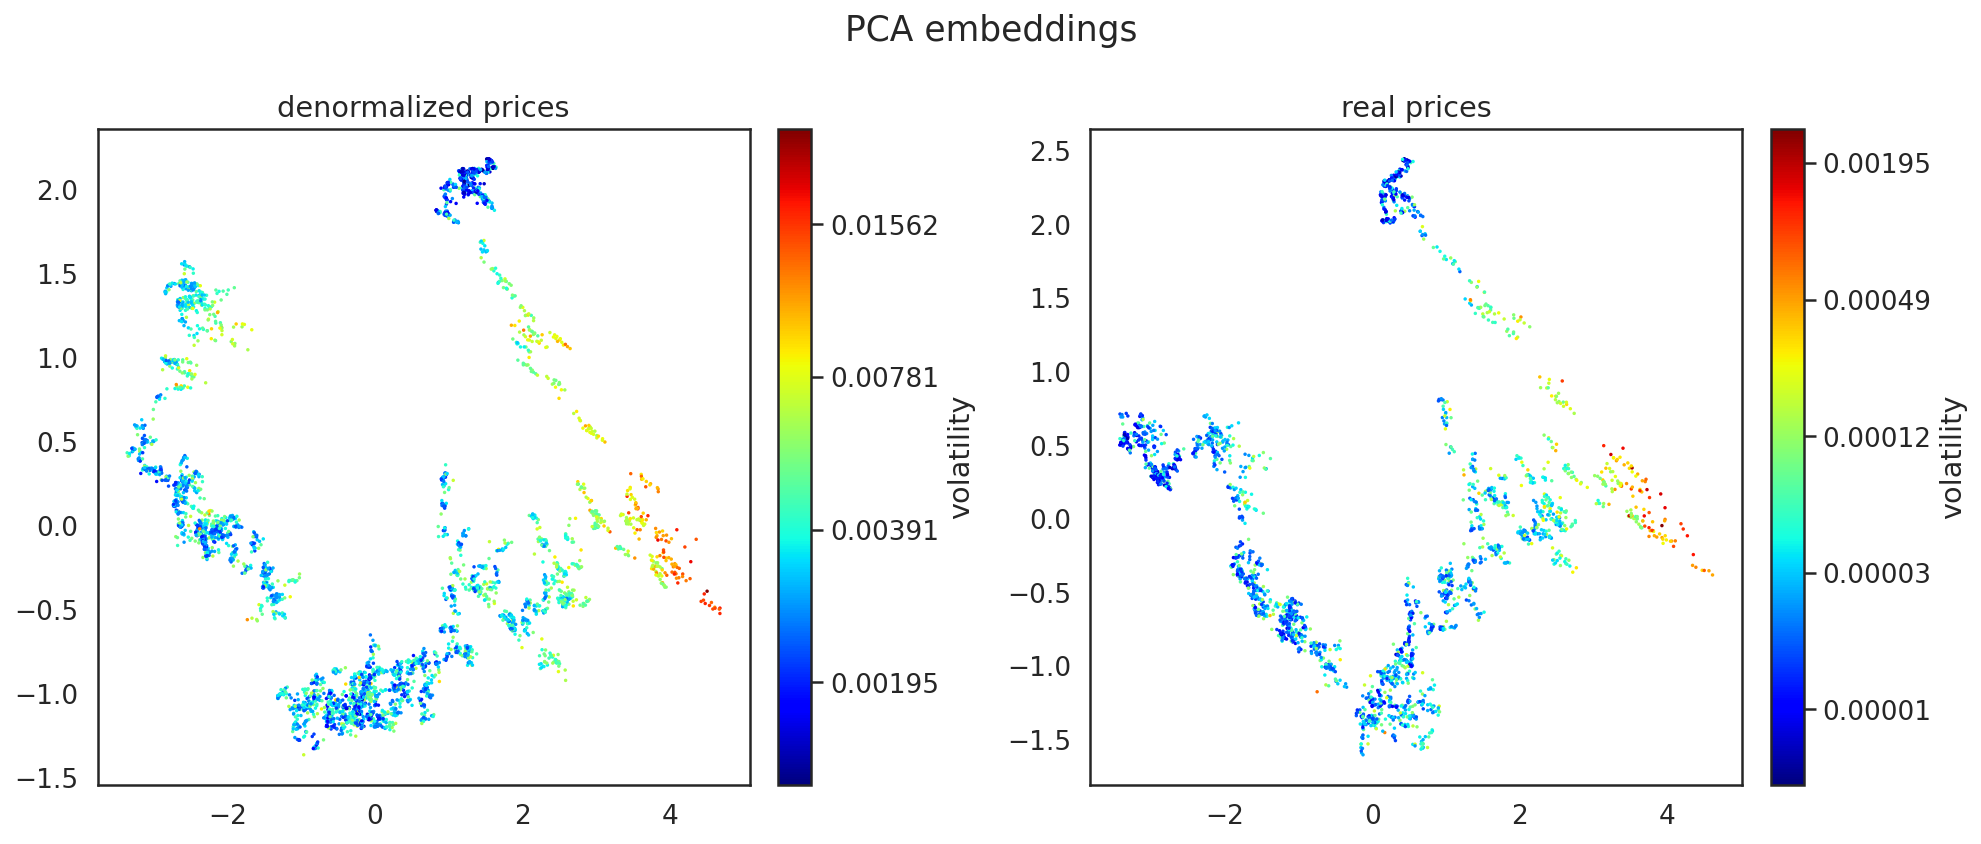

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = PCA(n_components=2)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('PCA embeddings')
plt.tight_layout()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3830 samples in 0.043s...
[t-SNE] Computed neighbors for 3830 samples in 0.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3830
[t-SNE] Computed conditional probabilities for sample 2000 / 3830
[t-SNE] Computed conditional probabilities for sample 3000 / 3830
[t-SNE] Computed conditional probabilities for sample 3830 / 3830
[t-SNE] Mean sigma: 0.232494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.317993
[t-SNE] KL divergence after 2000 iterations: 0.152247
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2479 samples in 0.027s...
[t-SNE] Computed neighbors for 2479 samples in 0.929s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2479
[t-SNE] Computed conditional probabilities for sample 2000 / 2479
[t-SNE] Computed conditional probabilities for sample 2479 / 2479
[t-SNE] Mean sigma: 0.266675
[t-SNE] KL divergence after 250 iterations with early exaggerati

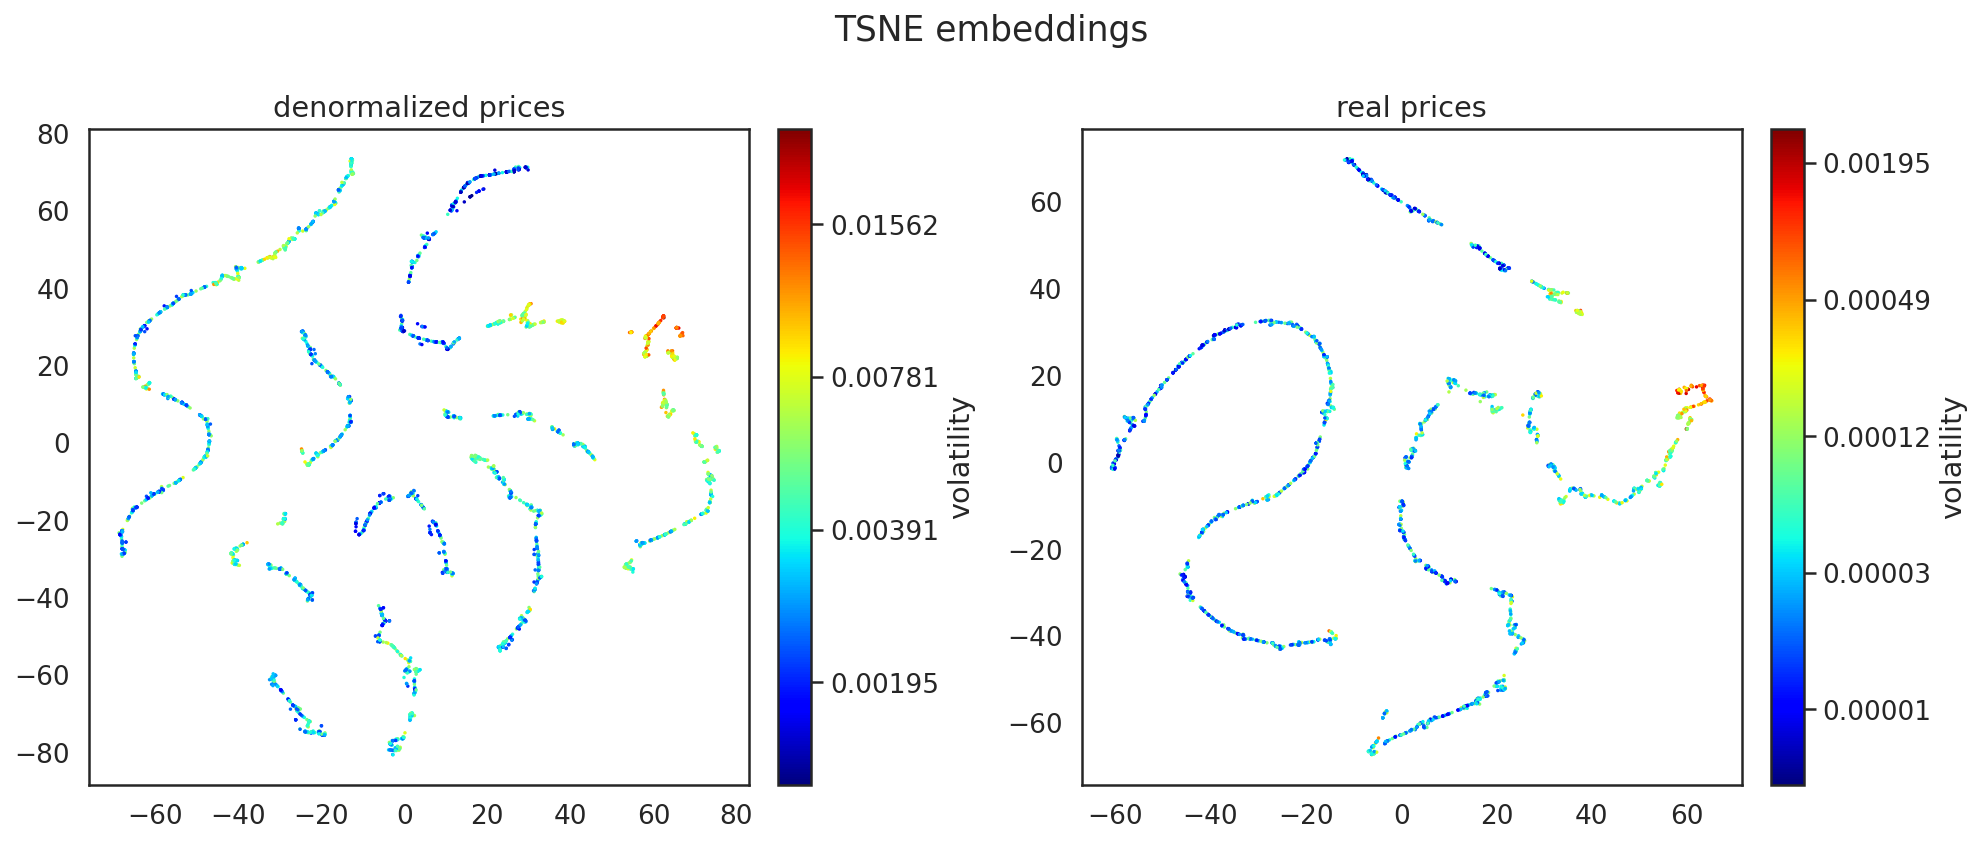

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = TSNE(n_components=2, perplexity=40, learning_rate=50, 
           verbose=1, init='pca', n_iter=2000,
           early_exaggeration=12)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('TSNE embeddings')
plt.tight_layout()

UMAP(dens_frac=0.0, dens_lambda=0.0, local_connectivity=1, low_memory=False,
     n_neighbors=60, repulsion_strength=1, spread=0.5,
     target_metric='euclidean', verbose=True)
Construct fuzzy simplicial set
Tue Sep 28 15:03:56 2021 Finding Nearest Neighbors
Tue Sep 28 15:04:00 2021 Finished Nearest Neighbor Search
Tue Sep 28 15:04:03 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Sep 28 15:04:14 2021 Finished embedding
UMAP(dens_frac=0.0, dens_lambda=0.0, local_connectivity=1, low_memory=False,
     n_neighbors=60, repulsion_strength=1, spread=0.5,
     target_metric='euclidean', verbose=True)
Construct fuzzy simplicial set
Tue Sep 28 15:04:20 2021 Finding Nearest Neighbors
Tue Sep 28 15:04:20 2021 F

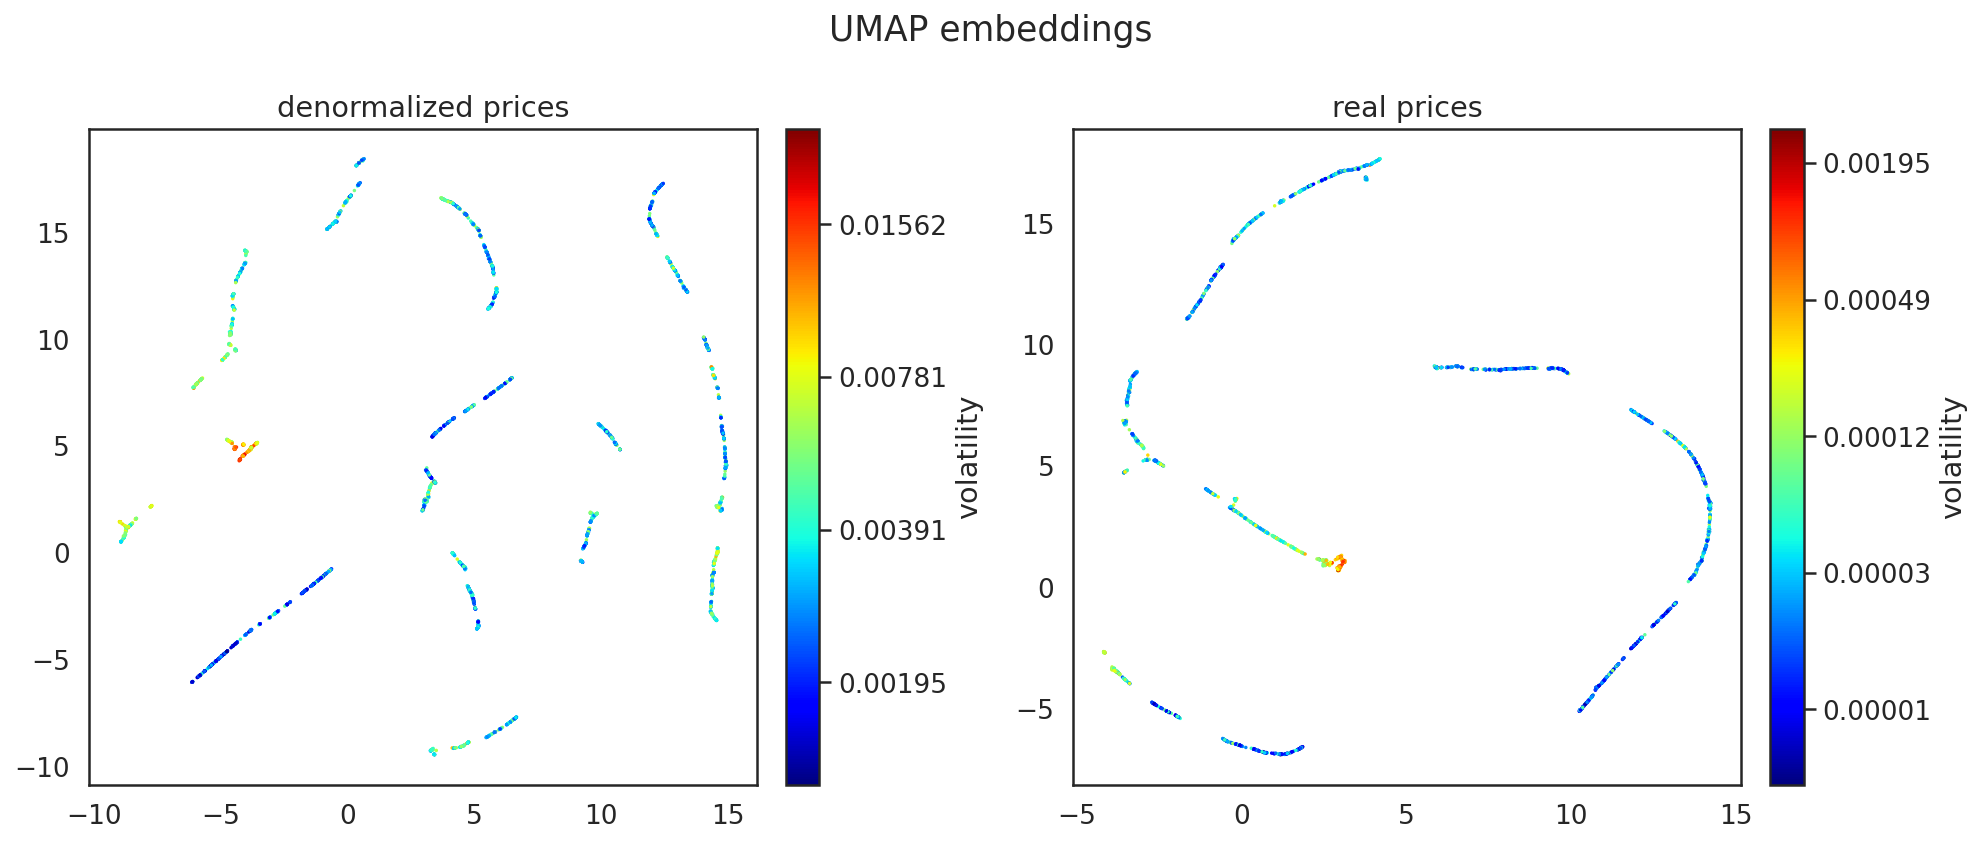

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = umap.UMAP(n_neighbors=60, min_dist=0.1, target_metric='euclidean', 
                init='spectral',  low_memory=False, verbose=True, 
                spread=0.5, local_connectivity=1, repulsion_strength=1, 
                negative_sample_rate=5)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('UMAP embeddings')
plt.tight_layout()

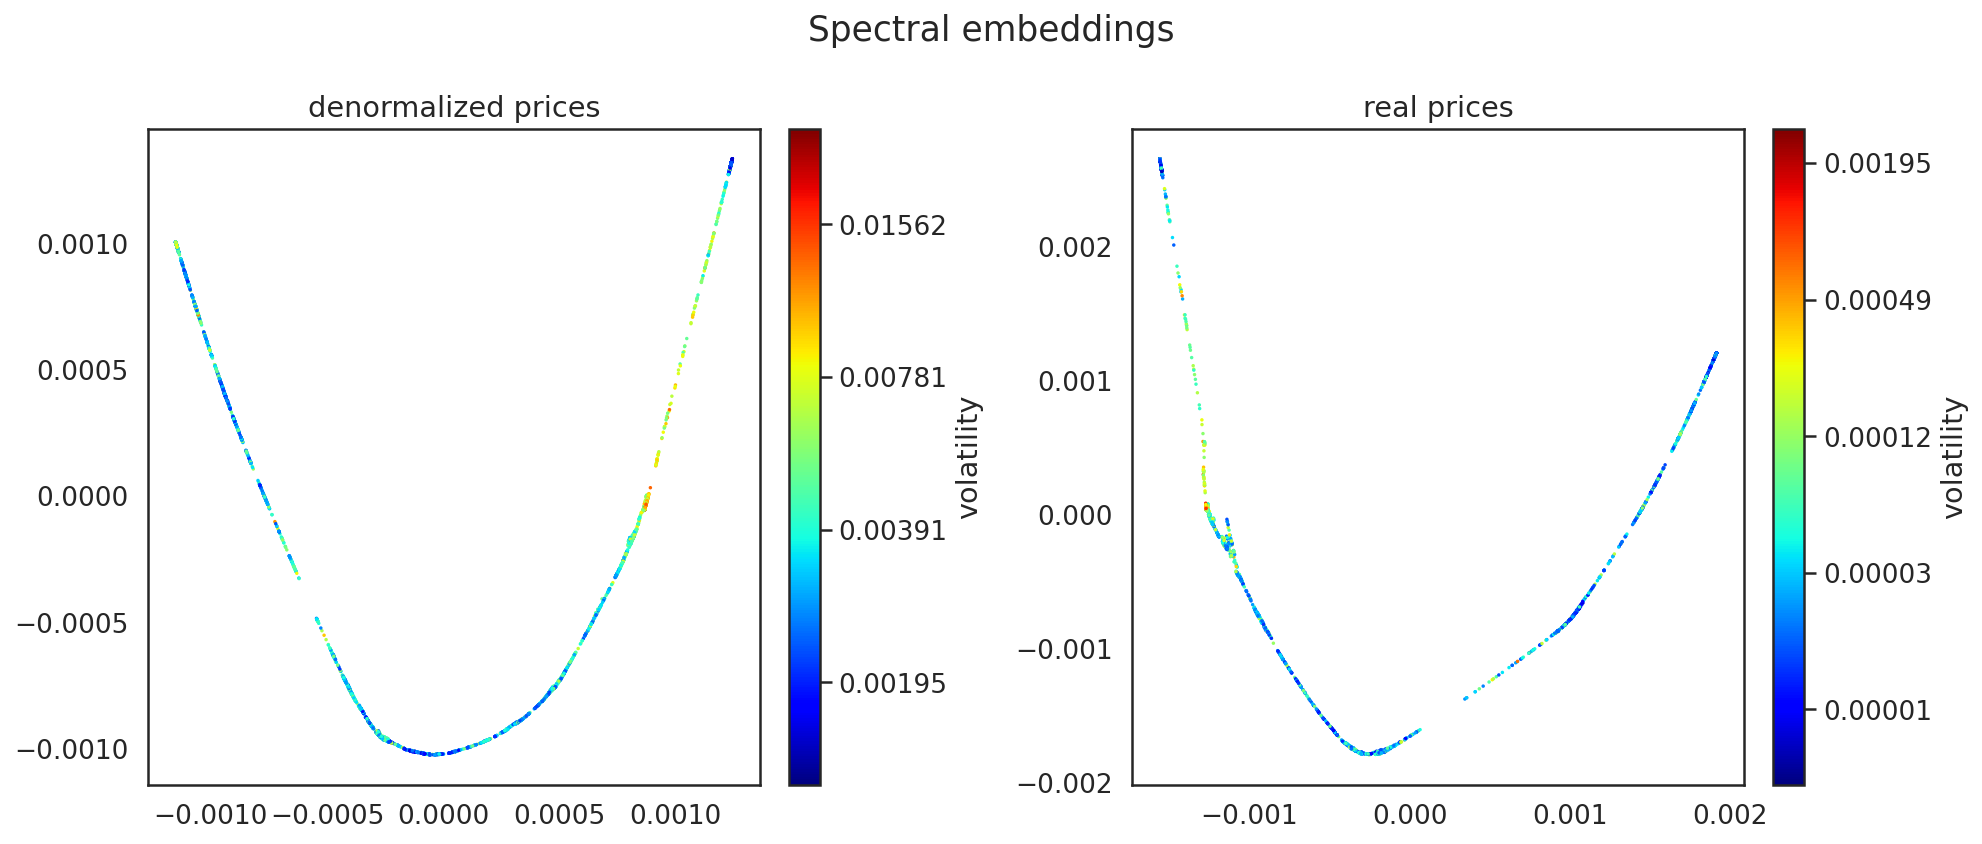

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = SpectralEmbedding(random_state=2)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('Spectral embeddings')
plt.tight_layout()

Well, there a few interesting insights from the plots above:
1. There are definetely a lot of similarities between embeddings of denorm prices vs real prices - both shapes and colors. This can confirm that price denormalization works correctly.
2. We indeed see long continuous segments as it was expected.
3. There is a single outstanding cluster of high volatility, and as we know that real data includes period of [2020 stock market crash](https://en.wikipedia.org/wiki/2020_stock_market_crash) we can pretty confidently assume that this is the same cluster in training data.
4. Spectral embeddings look very nice - there is single connected line and we can easily order all points from left to right.

To confirm our hypothesis that spectral embedding indeed sorts points by date, let's show the same plot but colorcode it by date, as we know it for real prices.

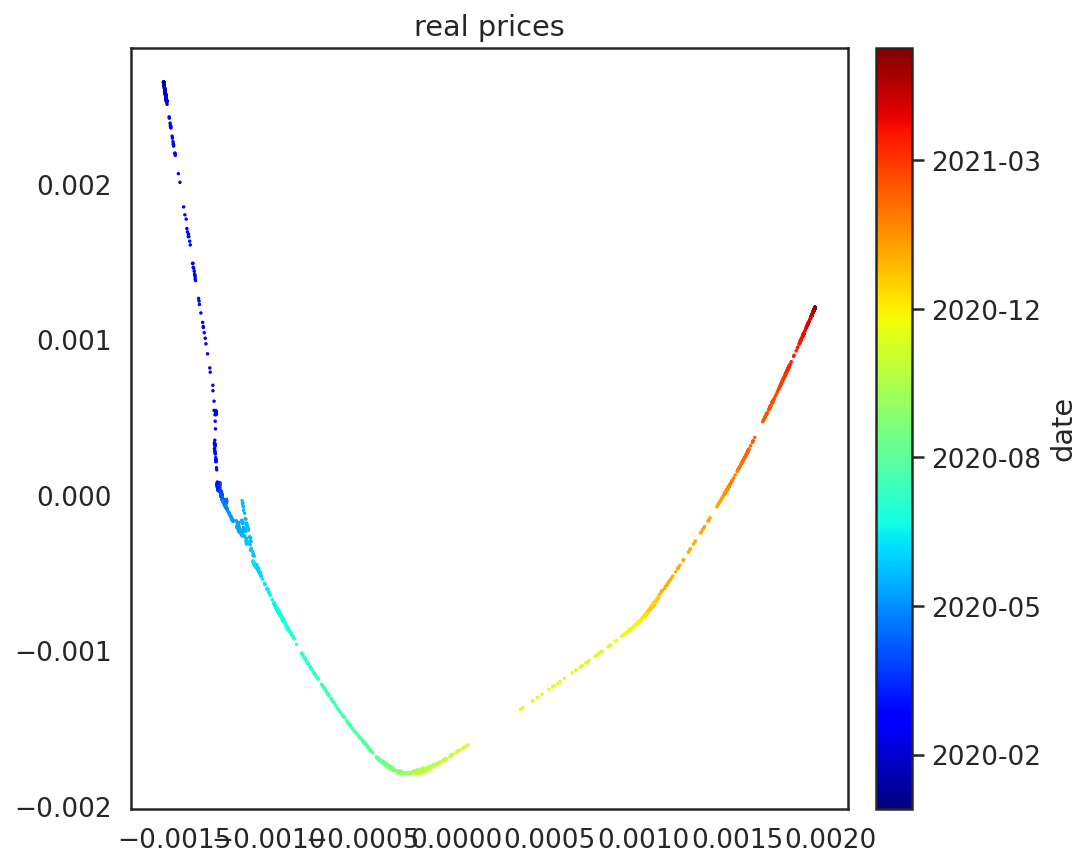

In [ ]:
plot_emb(emb_real, [mpl.dates.date2num(i) for i in df_volatility_real.index], 'real prices', 'date')

Cool! We can see, that spectral embedding indeed sorts all points by date. So we now can use X-coordinate of embeddings to approximately recover time order of time_ids in training data.

In [ ]:
df_prices_denorm_ordered = df_prices_denorm.iloc[np.argsort(-emb_denorm[:, 0])]

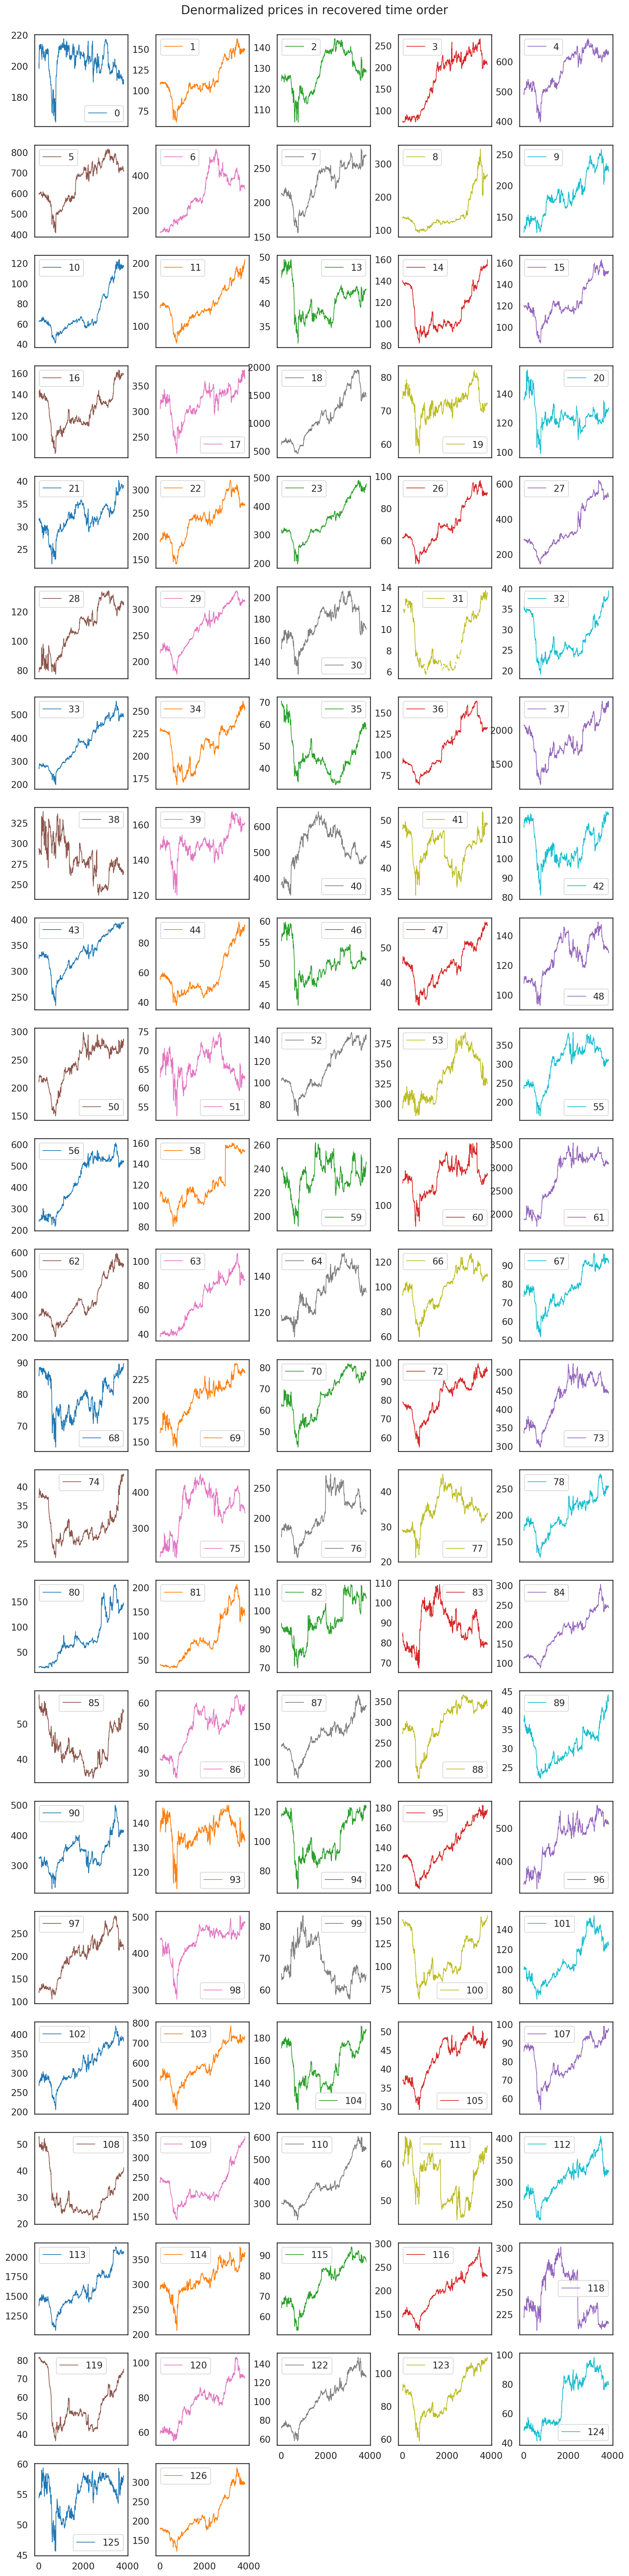

In [ ]:
df_prices_denorm_ordered.reset_index(drop=True).rolling(10).mean(). \
    plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1)
plt.suptitle('Denormalized prices in recovered time order')
plt.subplots_adjust(top=0.97, wspace=0.3);

Looks pretty reasonable - you can easily spot 2020 coronavirus crash with following upwards trend on many plots. 

Let's look at real prices for comparison:

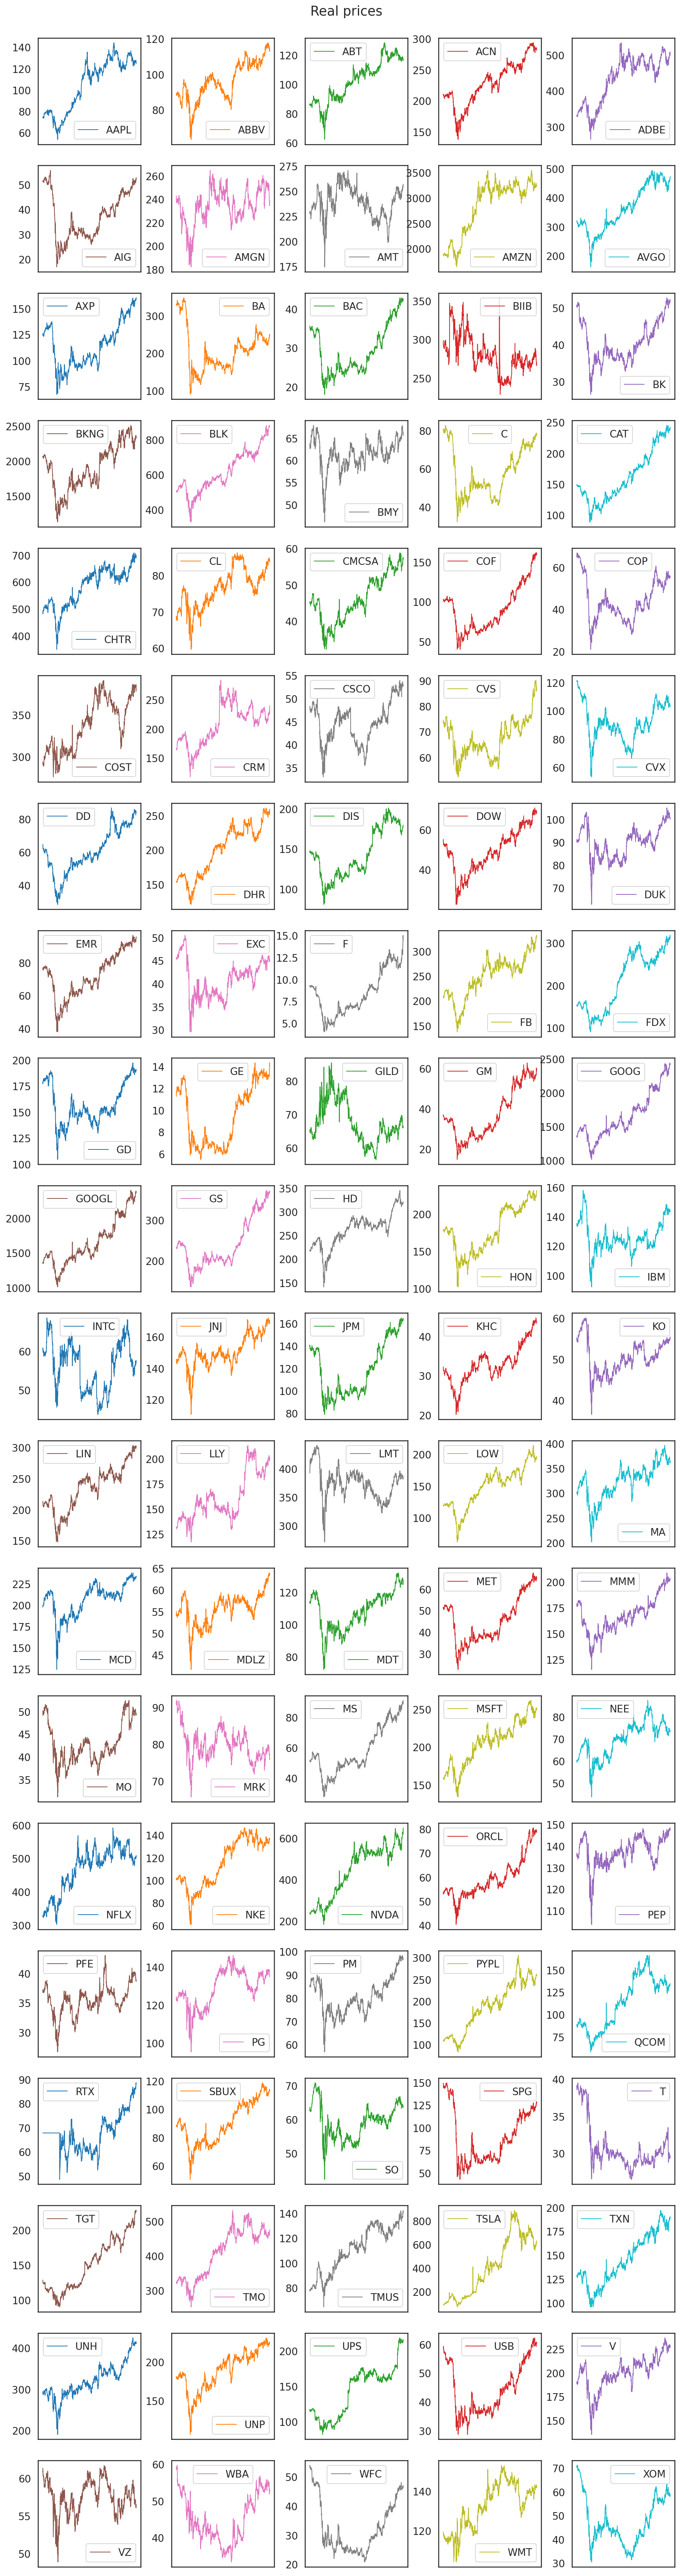

In [ ]:
df_prices_real.plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1);
plt.xticks([])
plt.suptitle('Real prices')
plt.subplots_adjust(top=0.97, wspace=0.3);

From denormalized prices distribution plot we can see that the most expensive stock (61) prices are in range 1800-3500, which matches AMZN prices for 2020-2021(half). Let's plot both of them in a single plot.

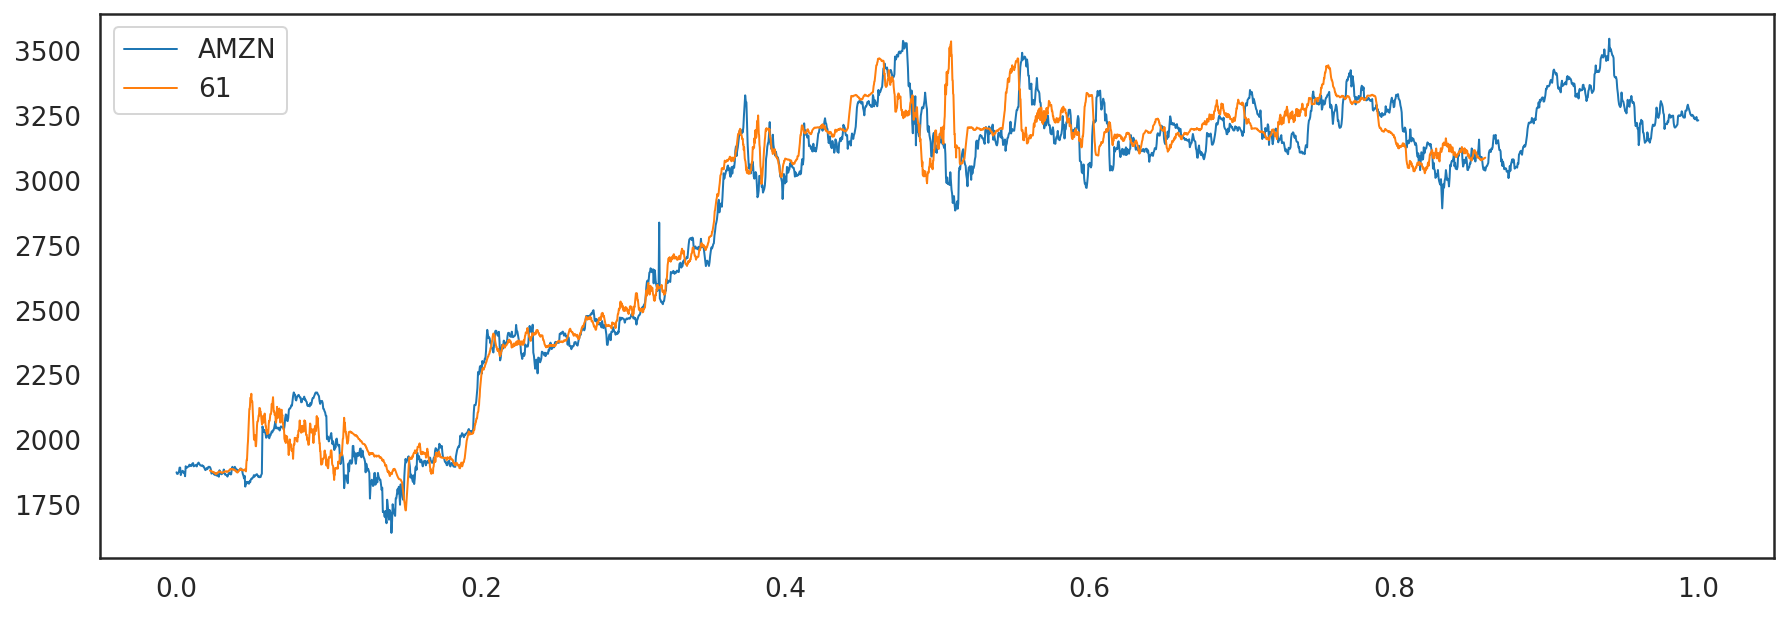

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
df_prices_real['AMZN'].sort_index().to_frame().set_index(np.linspace(0, 1, len(df_prices_real))).plot(lw=1, ax=ax)
df_prices_denorm_ordered[61].rolling(10).mean().to_frame().set_index(np.linspace(0.02, 0.86, len(df_prices_denorm_ordered))).plot(lw=1, ax=ax);

Another outstanding stock is 31 which has largest RMSPE and lowest price range 6-14. Looking through available real stocks charts we can notice that GE prices look suspiciously similar to it.

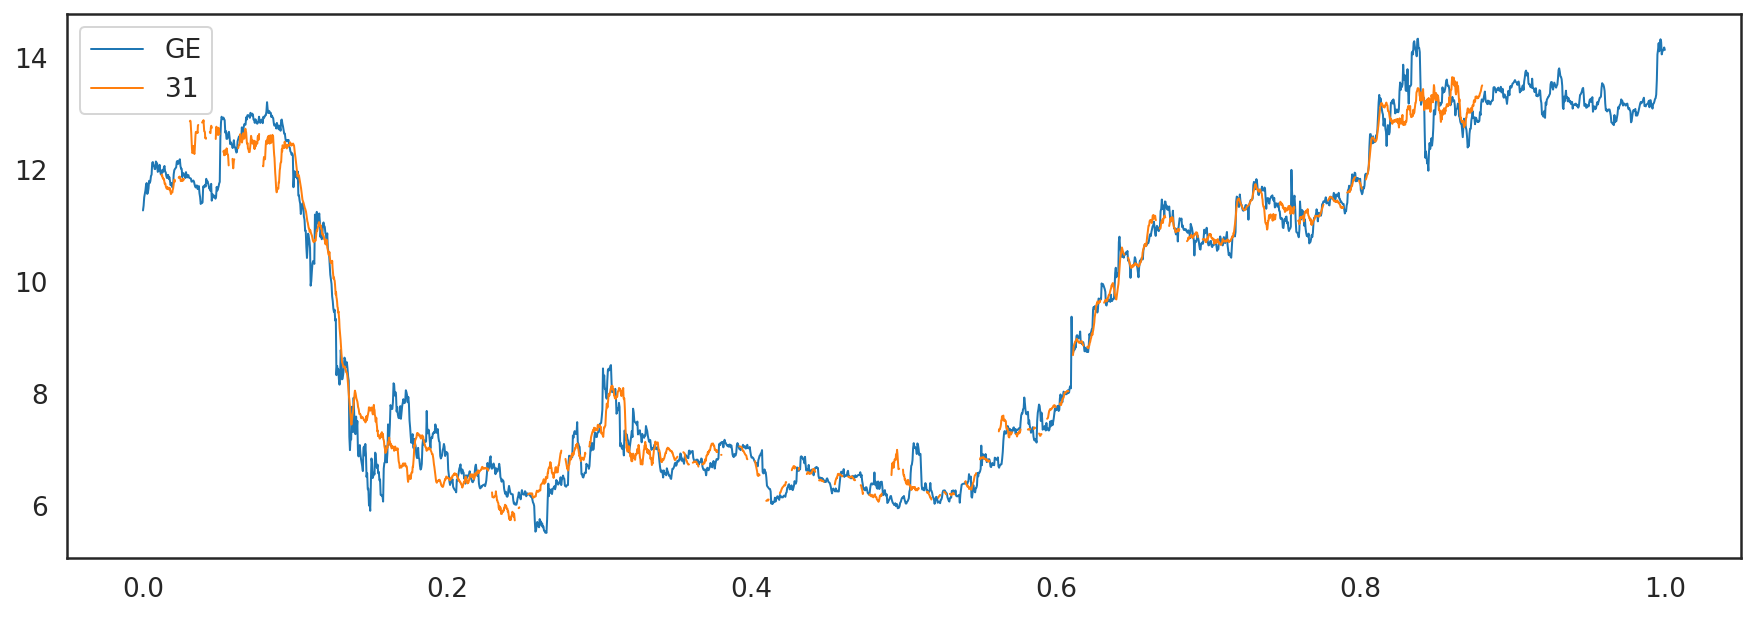

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
df_prices_real['GE'].sort_index().to_frame().set_index(np.linspace(0, 1, len(df_prices_real))).plot(lw=1, ax=ax)
df_prices_denorm_ordered[31].rolling(10).mean().to_frame().set_index(np.linspace(0, 0.88, len(df_prices_denorm_ordered))).plot(lw=1, ax=ax);

Poor General Electric, it really having a bad time in last years.

<img src="https://user-images.githubusercontent.com/4602302/135102010-fb45f4d9-4d00-4cdd-b571-47dc17f84ac3.png" width="50%"/>
<img src="https://user-images.githubusercontent.com/4602302/135102047-67745529-ef46-4cd2-b784-f79b41504168.png" width="50%"/>

*TODO: Use [Dynamic Time Warping](https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html) to match other stocks.*

### Can we utilize this additional information to improve our model score?

I can't say I found the best way to utilize it with maximum gain, considering that this time ordering method while recovering global order might be quite noisy locally. But one simple idea could be to feed into our model features from nearest time_ids besides current one.

Let's try it with the most basic linear model with one feature: current realized volatility.

In [ ]:
def calc_rv(r):
    df = pd.read_parquet(r.book_path)
    df['wap'] = (df.ask_price1 * df.bid_size1 + df.bid_price1 * df.ask_size1) / (df.ask_size1 + df.bid_size1)
    df = df.groupby('time_id').wap.apply(lambda x: (np.log(x).diff() ** 2).sum() ** 0.5).reset_index()
    df.rename(columns={'wap': 'rv'}, inplace=True)
    df['stock_id'] = r.stock_id
    return df
    
df_rv_train = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

Now we'll train a few models varying number of neighours we provide as input to select an optimal number based on CV.

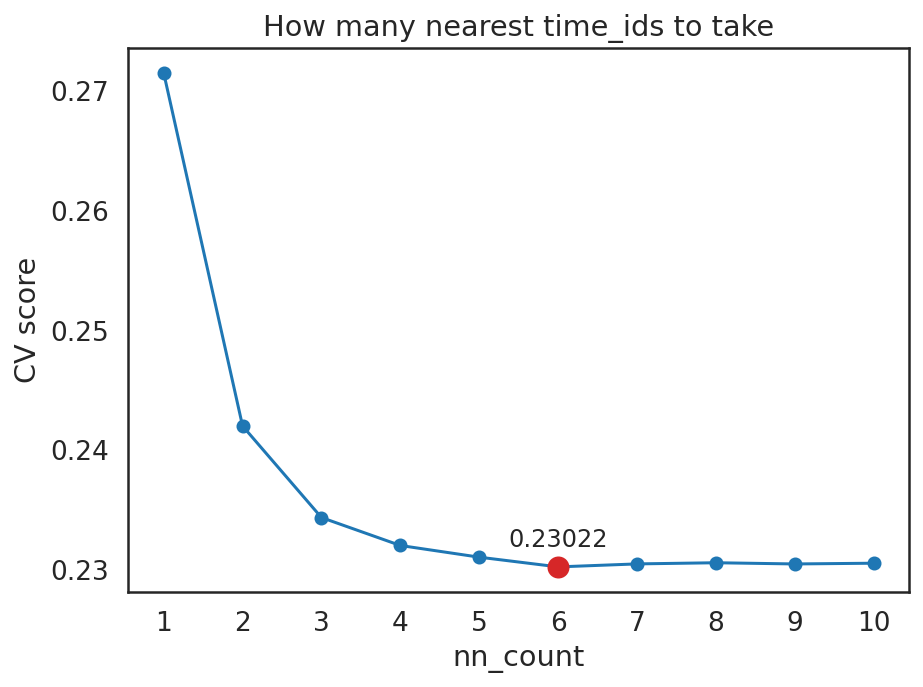

In [ ]:
nn = NearestNeighbors(algorithm='brute')
nn.fit(df_prices_denorm_scaled)
nn_ind = nn.kneighbors(df_prices_denorm_scaled, n_neighbors=10, return_distance=False)

results = []
for nn_count in range(1, 11):
    time_ind = df_target_train.time_id.factorize()[0]
    stock_ind = df_target_train.stock_id.factorize()[0]
    df_train = df_rv_train.pivot('time_id', 'stock_id', 'rv')
    
    # a bit of advanced indexing to gather nearest rv
    df_train = pd.DataFrame(df_train.values[
            nn_ind[time_ind, :nn_count],
            stock_ind[:, None]], 
        index=df_target_train.index)
    df_train.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
    df_train.fillna(df_train.mean(), inplace=True)

    model = LinearRegression()
    scores = cross_val_score(model, df_train, df_target_train.target, 
                             groups=df_target_train.time_id, 
                             scoring=make_scorer(rmspe),
                             fit_params={'sample_weight': 1 / df_target_train.target ** 2})
    
    results.append({'nn_count': nn_count, 'score': scores.mean()})
    
df_results = pd.DataFrame(results)
ax = df_results.plot(x='nn_count', y='score', style='-C0o', figsize=(7, 5), legend=False)
best = df_results.iloc[df_results.score.argmin()]
plt.plot(best.nn_count, best.score, 'C3o', markersize=10)
plt.annotate(f'{best.score:.5f}', xy=(best.nn_count, best.score), xytext=(0, 10), 
             fontsize=12, textcoords='offset points', ha='center')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('CV score')
plt.title('How many nearest time_ids to take');

In the plot above nn_count=1 effectively means we use only one feature - current realized volatility as input, and you can see that providing realized volatility from neighbour time_ids greatly improves the score from *0.27* to *0.23*, and it plateaus after nn_count > 6.

Finally let's train model using optimal nn_count=6 and use it for predicting on test.

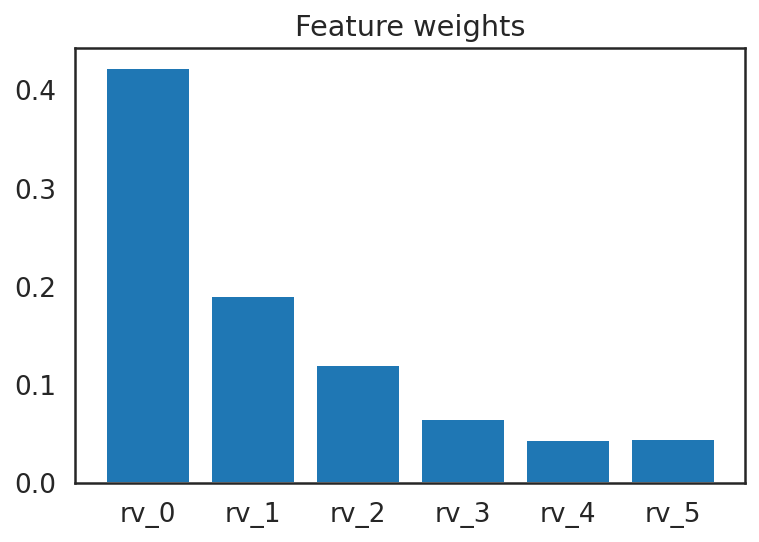

In [ ]:
nn_count = 6

time_ind = df_target_train.time_id.factorize()[0]
stock_ind = df_target_train.stock_id.factorize()[0]
df_train = df_rv_train.pivot('time_id', 'stock_id', 'rv')

df_train = pd.DataFrame(df_train.values[
        nn_ind[time_ind, :nn_count],
        stock_ind[:, None]], 
    index=df_target_train.index)
df_train.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
df_train.fillna(df_train.mean(), inplace=True)

model = LinearRegression()
model.fit(df_train, df_target_train.target, sample_weight=1 / df_target_train.target ** 2)

plt.bar(x=df_train.columns, height=model.coef_);
plt.title('Feature weights');

In [ ]:
df_files = pd.DataFrame({'book_path': glob(f'{data_dir}/book_test.parquet/**/*.parquet')}) \
    .assign(stock_id=lambda x: x.book_path.str.extract("stock_id=(\d+)").astype('int')) \
    .sort_values('stock_id')

df_submission = pd.read_csv(f'{data_dir}/test.csv')

df_prices_denorm_test = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
df_prices_denorm_test = df_prices_denorm_test.pivot('time_id', 'stock_id', 'price')
df_prices_denorm_scaled_test = df_prices_denorm_test.fillna(df_prices_denorm_test.mean())
df_prices_denorm_scaled_test = pd.DataFrame(minmax_scale(df_prices_denorm_scaled_test), index=df_prices_denorm_test.index)

df_rv_test = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

if len(df_prices_denorm_scaled_test) == 1:
    nn_ind = np.zeros((3, nn_count), dtype='int')
else:
    nn = NearestNeighbors(algorithm='brute')
    nn.fit(df_prices_denorm_scaled_test)
    nn_ind = nn.kneighbors(df_prices_denorm_scaled_test, n_neighbors=10, return_distance=False)

time_ind = df_submission.time_id.factorize()[0]
stock_ind = df_submission.stock_id.factorize()[0]
df_test = df_rv_test.pivot('time_id', 'stock_id', 'rv')

df_test = pd.DataFrame(df_test.values[
        nn_ind[time_ind, :nn_count],
        stock_ind[:, None]], 
    index=df_submission.index)
df_test.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

df_submission['target'] = model.predict(df_test)
df_submission = df_submission[['row_id', 'target']]
df_submission.to_csv('submission.csv', index=False)
df_submission.head()

row_id    target
0    0-4  0.000306
1   0-32  0.000306
2   0-34  0.000306

PLB of this submission was **0.21379**